In [18]:
#skfuzzy

"""
_normalize_columns.py : Normalize columns.
"""

import numpy as np


def normalize_columns(columns):
    """
    Normalize columns of matrix.

    Parameters
    ----------
    columns : 2d array (M x N)
        Matrix with columns

    Returns
    -------
    normalized_columns : 2d array (M x N)
        columns/np.sum(columns, axis=0, keepdims=1)
    """

    # broadcast sum over columns
    normalized_columns = columns/np.sum(columns, axis=0, keepdims=1)
    
    return normalized_columns


def normalize_power_columns(x, exponent):
    """
    Calculate normalize_columns(x**exponent)
    in a numerically safe manner.

    Parameters
    ----------
    x : 2d array (M x N)
        Matrix with columns
    n : float
        Exponent

    Returns
    -------
    result : 2d array (M x N)
        normalize_columns(x**n) but safe
    
    """

    assert np.all(x >= 0.0)

    x = x.astype(np.float64)
    
    # values in range [0, 1]
    x = x/np.max(x, axis=0, keepdims=True)

    # values in range [eps, 1]
    x = np.fmax(x, np.finfo(x.dtype).eps)

    if exponent < 0:
        # values in range [1, 1/eps]
        x /= np.min(x, axis=0, keepdims=True)
        
        # values in range [1, (1/eps)**exponent] where exponent < 0
        # this line might trigger an underflow warning
        # if (1/eps)**exponent becomes zero, but that's ok
        x = x**exponent
    else:
        # values in range [eps**exponent, 1] where exponent >= 0
        x = x**exponent

    result = normalize_columns(x)

    return result

In [19]:
"""
cmeans.py : Fuzzy C-means clustering algorithm.
"""
import numpy as np
from scipy.spatial.distance import cdist
#from .normalize_columns import normalize_columns, normalize_power_columns


def _cmeans0(data, u_old, c, m, metric):
    """
    Single step in generic fuzzy c-means clustering algorithm.

    Modified from Ross, Fuzzy Logic w/Engineering Applications (2010),
    pages 352-353, equations 10.28 - 10.35.

    Parameters inherited from cmeans()
    """
    # Normalizing, then eliminating any potential zero values.
    u_old = normalize_columns(u_old)
    u_old = np.fmax(u_old, np.finfo(np.float64).eps)

    um = u_old ** m

    # Calculate cluster centers
    data = data.T
    cntr = um.dot(data) / np.atleast_2d(um.sum(axis=1)).T

    d = _distance(data, cntr, metric)
    d = np.fmax(d, np.finfo(np.float64).eps)

    jm = (um * d ** 2).sum()

    u = normalize_power_columns(d, - 2. / (m - 1))

    return cntr, u, jm, d


def _distance(data, centers, metric='euclidean'):
    """
    Euclidean distance from each point to each cluster center.

    Parameters
    ----------
    data : 2d array (N x Q)
        Data to be analyzed. There are N data points.
    centers : 2d array (C x Q)
        Cluster centers. There are C clusters, with Q features.
    metric: string
        By default is set to euclidean. Passes any option accepted by
        ``scipy.spatial.distance.cdist``.
    Returns
    -------
    dist : 2d array (C x N)
        Euclidean distance from each point, to each cluster center.

    See Also
    --------
    scipy.spatial.distance.cdist
    """
    return cdist(data, centers, metric=metric).T


def _fp_coeff(u):
    """
    Fuzzy partition coefficient `fpc` relative to fuzzy c-partitioned
    matrix `u`. Measures 'fuzziness' in partitioned clustering.

    Parameters
    ----------
    u : 2d array (C, N)
        Fuzzy c-partitioned matrix; N = number of data points and C = number
        of clusters.

    Returns
    -------
    fpc : float
        Fuzzy partition coefficient.

    """
    n = u.shape[1]

    return np.trace(u.dot(u.T)) / float(n)


def cmeans(data, c, m, error, maxiter, metric='euclidean', init=None, seed=None):
    """
    Fuzzy c-means clustering algorithm [1].

    Parameters
    ----------
    data : 2d array, size (S, N)
        Data to be clustered.  N is the number of data sets; S is the number
        of features within each sample vector.
    c : int
        Desired number of clusters or classes.
    m : float
        Array exponentiation applied to the membership function u_old at each
        iteration, where U_new = u_old ** m.
    error : float
        Stopping criterion; stop early if the norm of (u[p] - u[p-1]) < error.
    maxiter : int
        Maximum number of iterations allowed.
    metric: string
        By default is set to euclidean. Passes any option accepted by
        ``scipy.spatial.distance.cdist``.
    init : 2d array, size (S, N)
        Initial fuzzy c-partitioned matrix. If none provided, algorithm is
        randomly initialized.
    seed : int
        If provided, sets random seed of init. No effect if init is
        provided. Mainly for debug/testing purposes.

    Returns
    -------
    cntr : 2d array, size (S, c)
        Cluster centers.  Data for each center along each feature provided
        for every cluster (of the `c` requested clusters).
    u : 2d array, (S, N)
        Final fuzzy c-partitioned matrix.
    u0 : 2d array, (S, N)
        Initial guess at fuzzy c-partitioned matrix (either provided init or
        random guess used if init was not provided).
    d : 2d array, (S, N)
        Final Euclidian distance matrix.
    jm : 1d array, length P
        Objective function history.
    p : int
        Number of iterations run.
    fpc : float
        Final fuzzy partition coefficient.


    Notes
    -----
    The algorithm implemented is from Ross et al. [1]_.

    Fuzzy C-Means has a known problem with high dimensionality datasets, where
    the majority of cluster centers are pulled into the overall center of
    gravity. If you are clustering data with very high dimensionality and
    encounter this issue, another clustering method may be required. For more
    information and the theory behind this, see Winkler et al. [2]_.

    References
    ----------
    .. [1] Ross, Timothy J. Fuzzy Logic With Engineering Applications, 3rd ed.
           Wiley. 2010. ISBN 978-0-470-74376-8 pp 352-353, eq 10.28 - 10.35.

    .. [2] Winkler, R., Klawonn, F., & Kruse, R. Fuzzy c-means in high
           dimensional spaces. 2012. Contemporary Theory and Pragmatic
           Approaches in Fuzzy Computing Utilization, 1.
    """
    # Setup u0
    if init is None:
        if seed is not None:
            np.random.seed(seed=seed)
        n = data.shape[1]
        u0 = np.random.rand(c, n)
        u0 = normalize_columns(u0)
        init = u0.copy()
    u0 = init
    u = np.fmax(u0, np.finfo(np.float64).eps)

    # Initialize loop parameters
    jm = np.zeros(0)
    p = 0

    # Main cmeans loop
    while p < maxiter - 1:
        u2 = u.copy()
        [cntr, u, Jjm, d] = _cmeans0(data, u2, c, m, metric)
        jm = np.hstack((jm, Jjm))
        p += 1

        # Stopping rule
        if np.linalg.norm(u - u2) < error:
            break

    # Final calculations
    error = np.linalg.norm(u - u2)
    fpc = _fp_coeff(u)

    return cntr, u, u0, d, jm, p, fpc


def cmeans_predict(test_data, cntr_trained, m, error, maxiter, metric='euclidean', init=None,
                   seed=None):
    """
    Prediction of new data in given a trained fuzzy c-means framework [1].

    Parameters
    ----------
    test_data : 2d array, size (S, N)
        New, independent data set to be predicted based on trained c-means
        from ``cmeans``. N is the number of data sets; S is the number of
        features within each sample vector.
    cntr_trained : 2d array, size (S, c)
        Location of trained centers from prior training c-means.
    m : float
        Array exponentiation applied to the membership function u_old at each
        iteration, where U_new = u_old ** m.
    error : float
        Stopping criterion; stop early if the norm of (u[p] - u[p-1]) < error.
    maxiter : int
        Maximum number of iterations allowed.
    metric: string
        By default is set to euclidean. Passes any option accepted by
        ``scipy.spatial.distance.cdist``.
    init : 2d array, size (S, N)
        Initial fuzzy c-partitioned matrix. If none provided, algorithm is
        randomly initialized.
    seed : int
        If provided, sets random seed of init. No effect if init is
        provided. Mainly for debug/testing purposes.

    Returns
    -------
    u : 2d array, (S, N)
        Final fuzzy c-partitioned matrix.
    u0 : 2d array, (S, N)
        Initial guess at fuzzy c-partitioned matrix (either provided init or
        random guess used if init was not provided).
    d : 2d array, (S, N)
        Final Euclidian distance matrix.
    jm : 1d array, length P
        Objective function history.
    p : int
        Number of iterations run.
    fpc : float
        Final fuzzy partition coefficient.

    Notes
    -----
    Ross et al. [1]_ did not include a prediction algorithm to go along with
    fuzzy c-means. This prediction algorithm works by repeating the clustering
    with fixed centers, then efficiently finds the fuzzy membership at all
    points.

    References
    ----------
    .. [1] Ross, Timothy J. Fuzzy Logic With Engineering Applications, 3rd ed.
           Wiley. 2010. ISBN 978-0-470-74376-8 pp 352-353, eq 10.28 - 10.35.
    """
    c = cntr_trained.shape[0]

    # Setup u0
    if init is None:
        if seed is not None:
            np.random.seed(seed=seed)
        n = test_data.shape[1]
        u0 = np.random.rand(c, n)
        u0 = normalize_columns(u0)
        init = u0.copy()
    u0 = init
    u = np.fmax(u0, np.finfo(np.float64).eps)

    # Initialize loop parameters
    jm = np.zeros(0)
    p = 0

    # Main cmeans loop
    while p < maxiter - 1:
        u2 = u.copy()
        [u, Jjm, d] = _cmeans_predict0(test_data, cntr_trained, u2, c, m, metric)
        jm = np.hstack((jm, Jjm))
        p += 1

        # Stopping rule
        if np.linalg.norm(u - u2) < error:
            break

    # Final calculations
    error = np.linalg.norm(u - u2)
    fpc = _fp_coeff(u)

    return u, u0, d, jm, p, fpc


def _cmeans_predict0(test_data, cntr, u_old, c, m, metric):
    """
    Single step in fuzzy c-means prediction algorithm. Clustering algorithm
    modified from Ross, Fuzzy Logic w/Engineering Applications (2010)
    p.352-353, equations 10.28 - 10.35, but this method to generate fuzzy
    predictions was independently derived by Josh Warner.

    Parameters inherited from cmeans()

    Very similar to initial clustering, except `cntr` is not updated, thus
    the new test data are forced into known (trained) clusters.
    """
    # Normalizing, then eliminating any potential zero values.
    u_old = normalize_columns(u_old)
    u_old = np.fmax(u_old, np.finfo(np.float64).eps)

    um = u_old ** m
    test_data = test_data.T

    # For prediction, we do not recalculate cluster centers. The test_data is
    # forced to conform to the prior clustering.

    d = _distance(test_data, cntr, metric)
    d = np.fmax(d, np.finfo(np.float64).eps)

    jm = (um * d ** 2).sum()

    u = normalize_power_columns(d, - 2. / (m - 1))

    return u, jm, d

Text(0.5,1,'Test data: 200 points x3 clusters.')

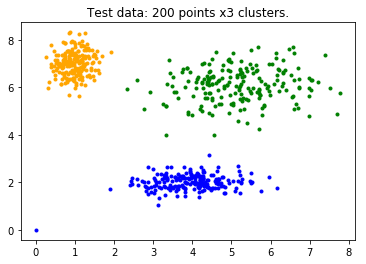

In [103]:
from __future__ import division, print_function
import numpy as np
import matplotlib.pyplot as plt
#import skfuzzy as fuzz

colors = ['b', 'orange', 'g', 'r', 'c', 'm', 'y', 'k', 'Brown', 'ForestGreen']

# Define three cluster centers
centers = [[4, 2],
           [1, 7],
           [5, 6]]

# Define three cluster sigmas in x and y, respectively
sigmas = [[0.8, 0.3],
          [0.3, 0.5],
          [1.1, 0.7]]

# Generate test data
np.random.seed(42)  # Set seed for reproducibility
xpts = np.zeros(1)
ypts = np.zeros(1)
labels = np.zeros(1)
for i, ((xmu, ymu), (xsigma, ysigma)) in enumerate(zip(centers, sigmas)):
    xpts = np.hstack((xpts, np.random.standard_normal(200) * xsigma + xmu))
    ypts = np.hstack((ypts, np.random.standard_normal(200) * ysigma + ymu))
    labels = np.hstack((labels, np.ones(200) * i))

# Visualize the test data
fig0, ax0 = plt.subplots()
for label in range(3):
    ax0.plot(xpts[labels == label], ypts[labels == label], '.',
             color=colors[label])
ax0.set_title('Test data: 200 points x3 clusters.')

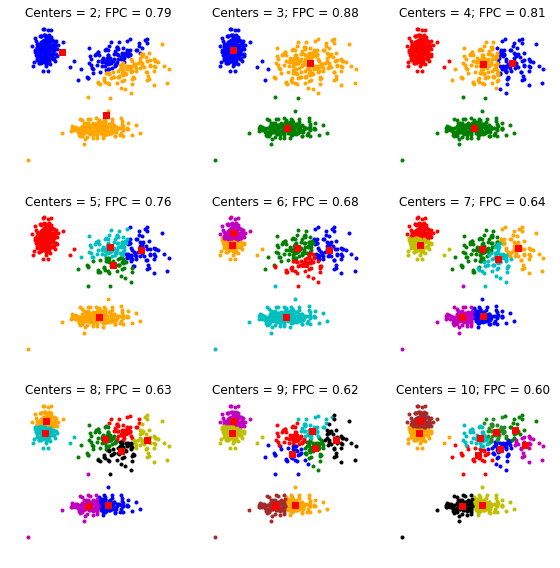

In [224]:
# Set up the loop and plot
fig1, axes1 = plt.subplots(3, 3, figsize=(8, 8))
alldata = np.vstack((xpts, ypts))
fpcs = []

for ncenters, ax in enumerate(axes1.reshape(-1), 2):
    #cmeans originated from cluster 
    cntr, u, u0, d, jm, p, fpc = cmeans(
        alldata, ncenters, 2, error=0.005, maxiter=1000, init=None)

    # Store fpc values for later
    fpcs.append(fpc)

    # Plot assigned clusters, for each data point in training set
    cluster_membership = np.argmax(u, axis=0)
    for j in range(ncenters):
        ax.plot(xpts[cluster_membership == j],
                ypts[cluster_membership == j], '.', color=colors[j])

    # Mark the center of each fuzzy cluster
    for pt in cntr:
        ax.plot(pt[0], pt[1], 'rs')

    ax.set_title('Centers = {0}; FPC = {1:.2f}'.format(ncenters, fpc))
    ax.axis('off')

fig1.tight_layout()

Text(0,0.5,'Fuzzy partition coefficient')

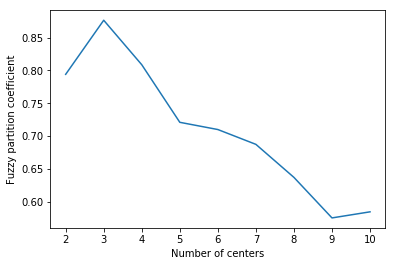

In [26]:
fig2, ax2 = plt.subplots()
ax2.plot(np.r_[2:11], fpcs)
ax2.set_xlabel("Number of centers")
ax2.set_ylabel("Fuzzy partition coefficient")

In [66]:
ncenters = 3
cntr, u, u0, d, jm, p, fpc = cmeans(
    alldata, ncenters, 2, error=0.005, maxiter=1000, init=None)

In [74]:
### Cluster membership, each documents gets a percentage membership for all clusters.
#### Very similar to LDA mixtures. 
print(u0[0][0])
print(u0[1][0])
print(u0[2][0])
print(u0[0][0] + u0[1][0]+  u0[2][0])

0.4079929402209117
0.2366711264442976
0.35533593333479074
1.0


In [75]:
#iris_target = data_iris.target

### Replace this with dtm for CFPB data 

import os 
import string
import pandas as pd 

#set working environment 
os.chdir("/home/spenser/Downloads/case_study")

#Import Data
CFPB_1 = pd.read_csv("cfpb_1.csv")

CFPB_2 = pd.read_csv("cfpb_2.csv", header = None)
CFPB_2.columns = ['complaint_id', 'text']

CFPB_3 = pd.read_csv("cfpb_3.csv", header = None)
CFPB_3.columns = ['complaint_id', 'text']

CFPB_4 = pd.read_csv("cfpb_4.csv", header = None)
CFPB_4.columns = ['complaint_id', 'text']

CFPB_5 = pd.read_csv("cfpb_5.csv", header = None)
CFPB_5.columns = ['complaint_id', 'text']

CFPB_text = pd.concat([CFPB_1, CFPB_2, CFPB_3, CFPB_4, CFPB_5])

file_no_text = pd.read_csv("cfpb_triage_case_study_notext.csv")

# Merging Case Study Files to Complaint IDs
CFPB_Case_Study_Joined = file_no_text.merge(CFPB_text, on = 'complaint_id', how ='left')


CFPB_Case_Study_Joined["text_lower"] = CFPB_Case_Study_Joined["text"].str.lower()

CFPB_Case_Study_Joined["text_lower"] = CFPB_Case_Study_Joined["text_lower"].str.replace(r'\nRevision: (\d+)\n', '') #remove digits

def remove_punctuations(text):
    for punctuation in string.punctuation:
        text = text.replace(punctuation, '')
    return text

CFPB_Case_Study_Joined["text_clean"] = CFPB_Case_Study_Joined['text_lower'].apply(remove_punctuations)  #remove punctuation

#Adding this due to finding below that pre-cleansed text is corrupt. (contains cases like can t) . Remove single stand-alone characters. ("a", "e", etc)

CFPB_Case_Study_Joined["text_clean"] = CFPB_Case_Study_Joined["text_clean"].str.replace(r'\b(?<=)[a-z](?=)\b', '') #remove single stand-alone characters.



###############

import gc

# Remove stop words.

## NLTK Stop words
#from nltk.corpus import stopwords
#stop_words = stopwords.words('english')

#CFPB_Case_Study_Joined['text_clean_stopwords'] = CFPB_Case_Study_Joined['text_clean'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)])) #stop word removal.

In [91]:
#### Due to memory errors, using doc2vec approach. This will reduce dimensionality. I am not sure at this time if this
### is appropriate for the quantum clustering methodology. 

import nltk
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

max_epochs = 15
vec_size = 50
alpha = 0.025


def tokenize_text(text):
    tokens = []
    for sent in nltk.sent_tokenize(text):
        for word in nltk.word_tokenize(sent):
            if len(word) < 2:
                continue
            tokens.append(word.lower())
    return tokens
train_tagged = CFPB_Case_Study_Joined.apply(
    lambda r: TaggedDocument(words=tokenize_text(r['text_clean_stopwords']), tags=[r.product_group]), axis=1)

    
NUM_VECTORS = 50

vector_count = NUM_VECTORS
model = Doc2Vec(size=vector_count, min_count=1, dm=0, iter=1,
                dm_mean=1, dbow_words=1, workers=12)
model.build_vocab(train_tagged)

for epoch in range(max_epochs):
    print ("Training epoch", epoch)
    model.train(train_tagged,  total_examples=model.corpus_count,  epochs=model.epochs)
    model.alpha -= 0.02
    model.min_alpha = model.alpha

Training epoch 0
Training epoch 1
Training epoch 2
Training epoch 3
Training epoch 4
Training epoch 5
Training epoch 6
Training epoch 7
Training epoch 8
Training epoch 9
Training epoch 10
Training epoch 11
Training epoch 12
Training epoch 13
Training epoch 14


In [92]:
def vec_for_learning(model, tagged_docs):
    sents = tagged_docs.values
    targets, regressors = zip(*[(doc.tags[0], model.infer_vector(doc.words, 0.03, steps=20)) for doc in sents])
    return targets, regressors


y_train, X_train = vec_for_learning(model, train_tagged)

In [93]:
X_train_array = np.array((X_train))
X_train_array.shape

(268701, 50)

In [94]:
ncenters = 3
cntr, u, u0, d, jm, p, fpc = cmeans(
    X_train_array, ncenters, 2, error=0.005, maxiter=1000, init=None)

In [95]:
### Cluster membership, each documents gets a percentage membership for all clusters.
#### Very similar to LDA mixtures. 
print(u0[0][0])
print(u0[1][0])
print(u0[2][0])
print(u0[0][0] + u0[1][0]+  u0[2][0])

0.15758174551044138
0.6935327065458702
0.14888554794368855
1.0


In [96]:
ncenters = 7
cntr, u, u0, d, jm, p, fpc = cmeans(
    X_train_array, ncenters, 2, error=0.005, maxiter=1000, init=None)

In [98]:
### Cluster membership, each documents gets a percentage membership for all clusters.
#### Very similar to LDA mixtures. 
print(u0[0][0])
print(u0[1][0])
print(u0[3][0])
print(u0[4][0])
print(u0[5][0])
print(u0[6][0])

print(u0[0][0] + u0[1][0]+  u0[2][0] +  u0[3][0] +  u0[4][0] +  u0[5][0] +  u0[6][0])

0.15111056579293788
0.00832985878520143
0.15318607173989465
0.18401661357677904
0.09257495655332981
0.1237342822772327
0.9999999999999999


In [107]:
alldata.shape 

(2, 601)

In [110]:
X_train_array.reshape(50, 268701)

array([[-0.03590767,  0.05431675, -0.07983976, ..., -0.01375154,
        -0.19558619, -0.12655321],
       [-0.12372468, -0.22800238,  0.08541942, ..., -0.1114824 ,
        -0.03570045,  0.03887852],
       [-0.04112551, -0.02737589,  0.0488846 , ..., -0.04766769,
        -0.10597399, -0.09380961],
       ...,
       [-0.03153783,  0.04132372,  0.01873543, ..., -0.02975014,
         0.1923187 , -0.17343031],
       [ 0.10799751, -0.22537063, -0.15701026, ...,  0.37415028,
        -0.19985275,  0.05403537],
       [-0.04307958,  0.00453554,  0.11450639, ..., -0.09002383,
         0.0072874 , -0.05814402]], dtype=float32)

In [290]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2,  whiten=True)
pca.fit(X_train_array)
X_pca = pca.transform(X_train_array)

xpts_pca = X_pca[:, 0]
ypts_pca = X_pca[:, 1]

In [293]:
X_pca.shape

(268701, 2)

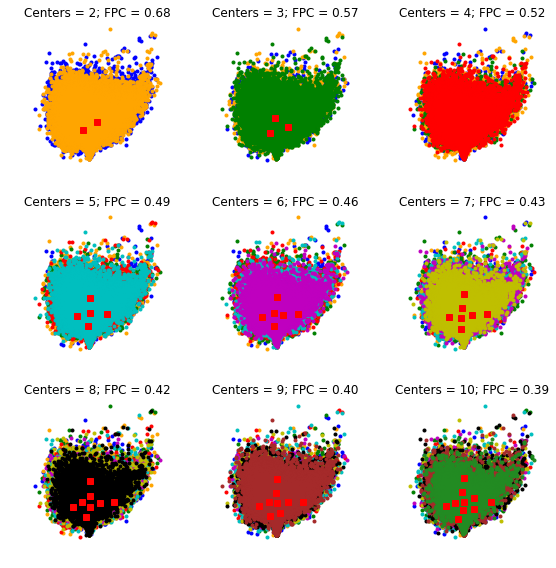

In [294]:
# Set up the loop and plot
fig1, axes1 = plt.subplots(3, 3, figsize=(8, 8))
alldata = np.vstack((xpts, ypts))
fpcs = []


for ncenters, ax in enumerate(axes1.reshape(-1), 2):
    #cmeans originated from cluster 
    
    
    ### Clustering the whole dataset (50 dimensions.) Plotting 
    cntr, u, u0, d, jm, p, fpc = cmeans(
        X_pca.reshape(2, 268701), ncenters, 2, error=0.005, maxiter=1000, init=None)

    # Store fpc values for later
    fpcs.append(fpc)


    # Plot assigned clusters, for each data point in training set
    cluster_membership = np.argmax(u, axis=0)
    for j in range(ncenters):
        ax.plot(xpts_pca[cluster_membership == j],
                ypts_pca[cluster_membership == j], '.', color=colors[j])

    # Mark the center of each fuzzy cluster
    for pt in cntr:
        ax.plot(pt[0], pt[1],  'rs')

    ax.set_title('Centers = {0}; FPC = {1:.2f}'.format(ncenters, fpc))
    ax.axis('off')

fig1.tight_layout()

Text(0,0.5,'Fuzzy partition coefficient')

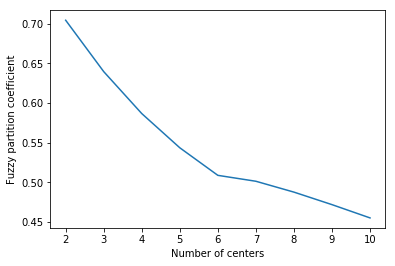

In [148]:
fig2, ax2 = plt.subplots()
ax2.plot(np.r_[2:11], fpcs)
ax2.set_xlabel("Number of centers")
ax2.set_ylabel("Fuzzy partition coefficient")

In [222]:
[enumerate(ax3.reshape(-1), 2)]

AttributeError: 'Axes3DSubplot' object has no attribute 'reshape'

In [173]:
from gensim.models import word2vec


def tokenize_text(text):
    tokens = []
    for sent in nltk.sent_tokenize(text):
        for word in nltk.word_tokenize(sent):
            if len(word) < 2:
                continue
            tokens.append(word.lower())
    return tokens
train_tagged = CFPB_Case_Study_Joined.apply(
    lambda r: TaggedDocument(words=tokenize_text(r['text_clean_stopwords']), tags=[r.product_group]), axis=1)




In [176]:

#model = Word2Vec(CFPB_Case_Study_Joined["text_clean"], size=100, window=5, min_count=5, workers=4)
model_d2v = Doc2Vec(size=50, min_count=1, dm=0, iter=1,
                dm_mean=1, dbow_words=1, workers=12)

model_d2v.build_vocab(train_tagged)
model_d2v.train(train_tagged, total_examples=model.corpus_count, epochs=2)

In [180]:
def vec_for_learning(model, tagged_docs):
    sents = tagged_docs.values
    targets, regressors = zip(*[(doc.tags[0], model.infer_vector(doc.words, 0.03, steps=20)) for doc in sents])
    return targets, regressors


y_train, X_train = vec_for_learning(model_d2v, train_tagged)

10
AxesSubplot(0.125,0.125;0.0731132x0.755)
10
AxesSubplot(0.212736,0.125;0.0731132x0.755)
10
AxesSubplot(0.300472,0.125;0.0731132x0.755)
10
AxesSubplot(0.388208,0.125;0.0731132x0.755)
10
AxesSubplot(0.475943,0.125;0.0731132x0.755)
10
AxesSubplot(0.563679,0.125;0.0731132x0.755)
10
AxesSubplot(0.651415,0.125;0.0731132x0.755)
10
AxesSubplot(0.739151,0.125;0.0731132x0.755)
10
AxesSubplot(0.826887,0.125;0.0731132x0.755)


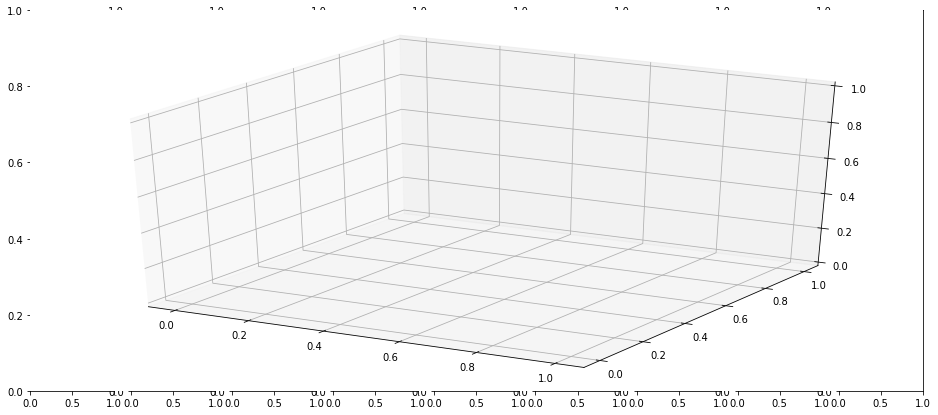

In [283]:
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
#fig = plt.figure()
#ax3 = fig.add_subplot(111, projection='3d')

#Axes3D.plot_surface(X, Y, Z, *args, **kwargs)


X_train_array = np.array((X_train))
X_train_array.shape


pca = PCA(n_components=3,  whiten=True)
pca.fit(X_train_array)
X_pca = pca.transform(X_train_array)

xpts_pca = X_pca[:, 0]
ypts_pca = X_pca[:, 1]
zpts_pca = X_pca[:, 2]



# Set up the loop and plot
#fig3, ax3 = plt.subplots(3, 3, figsize=(8, 8))
fig3 = plt.figure()
#ax3 = fig3.add_subplot(333, projection='3d')

fig, axes = plt.subplots(1, 9, figsize=(16, 7))
#alldata = np.vstack((xpts, ypts))
fpcs = []

#Change this to account for true axes: 
k = [2,3,4,5,6,7,8,9]
for ax in axes:
    #cmeans originated from cluster 
    n = 2
    print(ncenters)
    print(ax)
    ### Clustering the whole dataset (50 dimensions.) Plotting 
    cntr, u, u0, d, jm, p, fpc = cmeans(
        X_pca.reshape(3, 268701), n, 2, error=0.005, maxiter=1000, init=None)

    # Store fpc values for later
    fpcs.append(fpc)

    color_vec = ['b', 'orange', 'g', 'r', 'c', 'm', 'y', 'k', 'Brown', 'ForestGreen']
    # Plot assigned clusters, for each data point in training set
    cluster_membership = np.argmax(u, axis=0)
    for j in k:
        if j ==2:
            ax = fig.add_subplot(111, projection='3d')
            ax.scatter(xpts_pca[cluster_membership == j],
                        ypts_pca[cluster_membership == j], 
                        zpts_pca[cluster_membership == j], color=color_vec[j])
        if j > 2:
            ax = fig.add_subplot(111, projection='3d')
            ax.scatter(xpts_pca[cluster_membership == j],
                        ypts_pca[cluster_membership == j], 
                        zpts_pca[cluster_membership == j], color=color_vec[j])
            
    n += 1
    # Mark the center of each fuzzy cluster
    #for pt in cntr:
        #ax3.plot(pt[0], pt[1], pt[2], 'rs')


10
Axes3DSubplot(0.125,0.125;0.775x0.755)


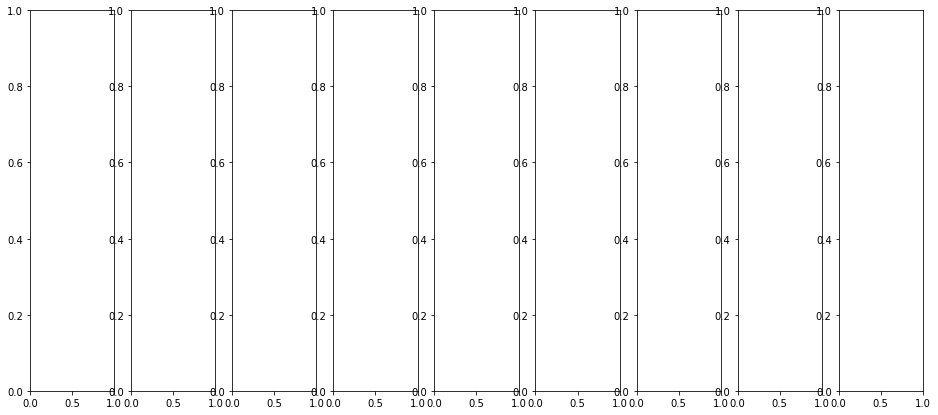

In [287]:
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
#fig = plt.figure()
#ax3 = fig.add_subplot(111, projection='3d')

#Axes3D.plot_surface(X, Y, Z, *args, **kwargs)


X_train_array = np.array((X_train))
X_train_array.shape


pca = PCA(n_components=3,  whiten=True)
pca.fit(X_train_array)
X_pca = pca.transform(X_train_array)

xpts_pca = X_pca[:, 0]
ypts_pca = X_pca[:, 1]
zpts_pca = X_pca[:, 2]



# Set up the loop and plot
#fig3, ax3 = plt.subplots(3, 3, figsize=(8, 8))
fig3 = plt.figure()
#ax3 = fig3.add_subplot(333, projection='3d')

fig, axes = plt.subplots(1, 9, figsize=(16, 7))
#alldata = np.vstack((xpts, ypts))
fpcs = []

#Change this to account for true axes: 
k = [2,3,4,5,6,7,8,9]

#cmeans originated from cluster 
n = 2
print(ncenters)
print(ax)
### Clustering the whole dataset (50 dimensions.) Plotting 
cntr, u, u0, d, jm, p, fpc = cmeans(
    X_pca.reshape(3, 268701), n, 2, error=0.005, maxiter=1000, init=None)

# Store fpc values for later
fpcs.append(fpc)

color_vec = ['b', 'orange', 'g', 'r', 'c', 'm', 'y', 'k', 'Brown', 'ForestGreen']
# Plot assigned clusters, for each data point in training set
cluster_membership = np.argmax(u, axis=0)
#ax = fig.add_subplot(111, projection='3d')
ax.scatter(xpts_pca[cluster_membership == j],
ypts_pca[cluster_membership == j], 
zpts_pca[cluster_membership == j], color=color_vec[j])ax = fig.add_subplot(111, projection='3d')
ax.scatter(xpts_pca[cluster_membership == j],
ypts_pca[cluster_membership == j], 
zpts_pca[cluster_membership == j], color=color_vec[j])



# Mark the center of each fuzzy cluster

In [276]:
from mpl_toolkits.mplot3d.axes3d import Axes3D
import matplotlib.pyplot as plt


# imports specific to the plots in this example
import numpy as np
from matplotlib import cm
from mpl_toolkits.mplot3d.axes3d import get_test_data

# Twice as wide as it is tall.
fig = plt.figure(figsize=plt.figaspect(0.5))

#---- First subplot
ax = fig.add_subplot(1, 2, 1, projection='3d')
X = np.arange(-5, 5, 0.25)
Y = np.arange(-5, 5, 0.25)
X, Y = np.meshgrid(X, Y)
R = np.sqrt(X**2 + Y**2)
Z = np.sin(R)
surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
ax.set_zlim3d(-1.01, 1.01)

fig.colorbar(surf, shrink=0.5, aspect=10)

#---- Second subplot
ax = fig.add_subplot(1, 2, 2, projection='3d')
X, Y, Z = get_test_data(0.05)
ax.plot_wireframe(X, Y, Z, rstride=10, cstride=10)

plt.show()

AxesSubplot(0.212736,0.125;0.0731132x0.755)


In [285]:
fig,axes = plt.subplots(1, 9, projection='3d', figsize=(16, 7))

#@fig.add_subplot(1, 1, 1, projection='3d')

TypeError: __init__() got an unexpected keyword argument 'projection'

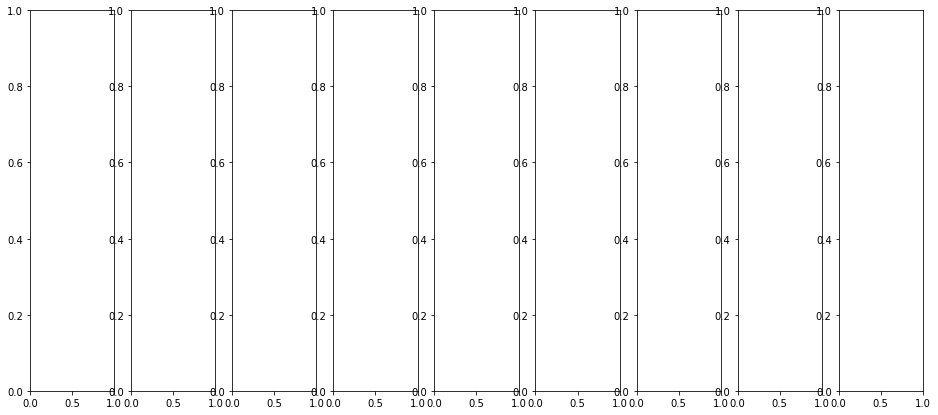

In [270]:
fig, (ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9) = plt.subplots(1, 9, figsize=(16, 7))

In [271]:
ax9